In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [10]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [11]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-02-04 20:48:52--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4005:813::201b, 2404:6800:4005:814::201b, 2404:6800:4005:804::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4005:813::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv.3’

Sunspots.csv.3      100%[===================>]  69,17K  --.-KB/s    in 0,07s   

2024-02-04 20:48:53 (982 KB/s) - ‘Sunspots.csv.3’ saved [70827/70827]



In [12]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


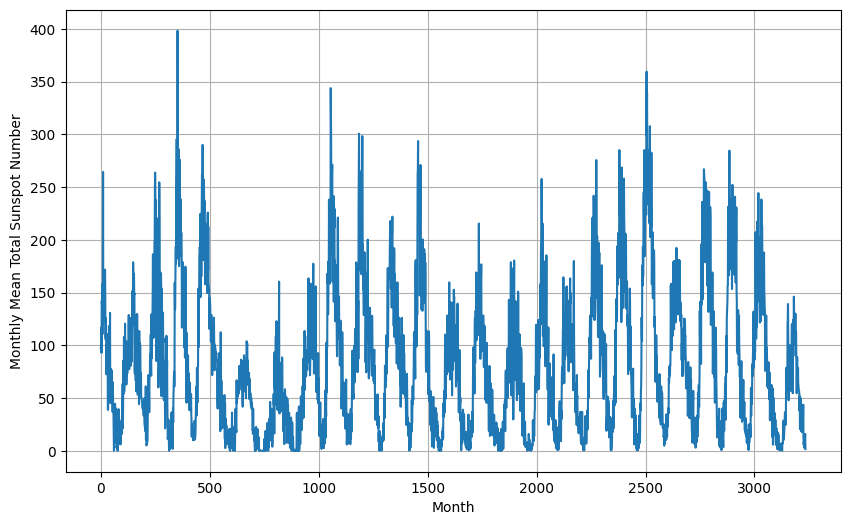

In [13]:
# Initialize lists
time_step = []
sunspots = []

# Openv CSV file
with open('./Sunspots.csv') as csvfile:
    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')
    # Skip the first line
    next(reader)
    # Append row and sunspot number to lists
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [14]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [16]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [17]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 1s 1ms/step - loss: 117.2705 - lr: 1.0000e-08
Epoch 2/100
 1/93 [..............................] - ETA: 2s - loss: 105.2592

2024-02-04 20:49:06.777575: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


93/93 [==============================] - 0s 848us/step - loss: 115.9033 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 0s 868us/step - loss: 114.3619 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 0s 940us/step - loss: 112.6415 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 0s 849us/step - loss: 110.7238 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 0s 757us/step - loss: 108.5858 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 0s 740us/step - loss: 106.2036 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 0s 819us/step - loss: 103.5475 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 0s 803us/step - loss: 100.5926 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 0s 875us/step - loss: 97.3189 - lr: 2.8184e-08
Epoch 11/100
93/93 [==============================] - 0s 863us/step - loss: 93.6851 - lr: 3.1623e-08
Ep

(1e-08, 0.001, 0.0, 100.0)

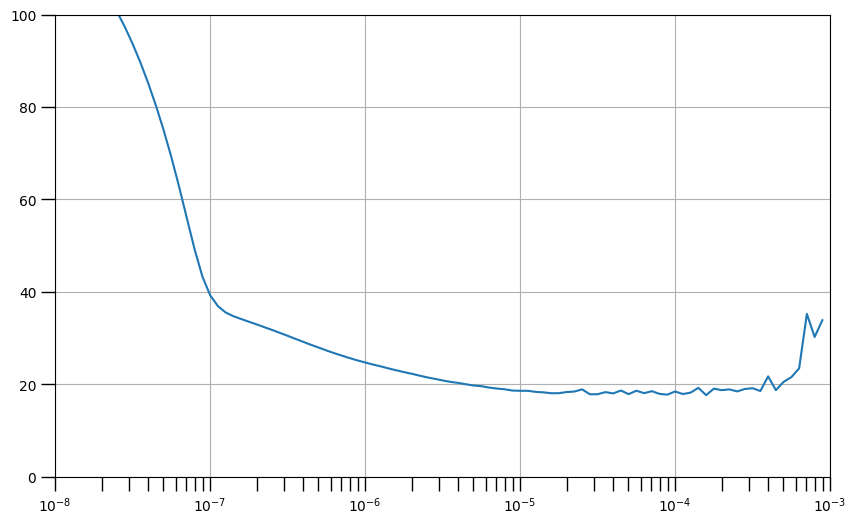

In [19]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [20]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [21]:
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 0s 1ms/step - loss: 30.6299 - mae: 31.1226
Epoch 2/100
93/93 [==============================] - 0s 971us/step - loss: 19.1208 - mae: 19.6127
Epoch 3/100
93/93 [==============================] - 0s 958us/step - loss: 18.4143 - mae: 18.9053
Epoch 4/100
93/93 [==============================] - 0s 960us/step - loss: 18.8708 - mae: 19.3620
Epoch 5/100
93/93 [==============================] - 0s 874us/step - loss: 18.2205 - mae: 18.7133
Epoch 6/100
93/93 [==============================] - 0s 874us/step - loss: 18.1717 - mae: 18.6624
Epoch 7/100
93/93 [==============================] - 0s 846us/step - loss: 17.4772 - mae: 17.9686
Epoch 8/100
93/93 [==============================] - 0s 999us/step - loss: 17.7011 - mae: 18.1924
Epoch 9/100
93/93 [==============================] - 0s 1ms/step - loss: 17.4273 - mae: 17.9194
Epoch 10/100
93/93 [==============================] - 0s 1ms/step - loss: 17.3762 - mae: 17.8677
Epoch 11/100
93/93 [=====

In [22]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

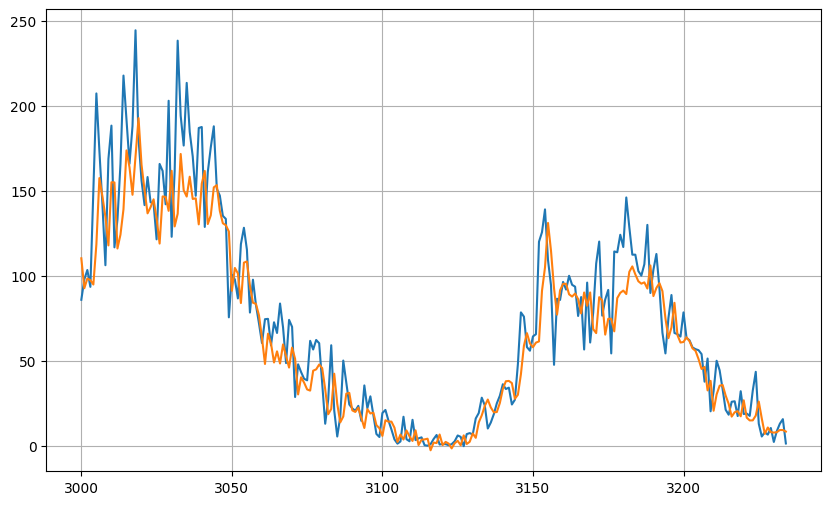

In [23]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [24]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

15.502816
